# HPC reconstrói imagens com Algoritmos Genéticos
### Integrantes: Alice Barbarino, Bruno Brischi, Maria Eduarda Crist

## Introdução


Algoritmos genéticos são ferramentas poderosas, inspirados na biologia e que auxiliam na resolução de problemas de otimização, sendo muito populares pela sua capacidade de evoluirem e conseguirem soluções melhores com o decorrer do tempo, sendo uma alternativa aos métodos de otimização por busca em grade e busca aleatória $[1][2]$. Assim, a reconstrução de imagens é um método importante em processamento de imagem, já que pode ser aplicada em recuperar imagens corrompidas e redução de ruído $[3]$. 

Então, a partir da leitura da referência $[4]$, um livro sobre algoritmos genéticos com python, decidimos implementar e estudar sobre o método de reconstrução de imagem criado pelos autores. Este é baseado em reconstruir a imagem usando polígonos com cor e opacidade variável. Dessa forma, neste trabalho, esperamos que as mudanças propostas melhorem a solução do problema, além de aprendermos sobre algoritmos genéticos em problemas com funções contínuas e alguns conceitos básicos de processamento de imagem.

## Funções de processamento de imagem

Antes de entramos no problema, é muito importante que uma breve introdução sobre processamento de imagem seja dada. No caso, vamos usar três bibliotecas principais para processá-las: `PIL`, `sklearn` e `cv2` (OpenCV). Usando o `PIL`, podemos criar uma imagem vazia de tamanho variável e desenhar polígonos nela usando as classes `Image`e `ImageDraw`, respectivamente. Vamos tentar fazer isso, então.

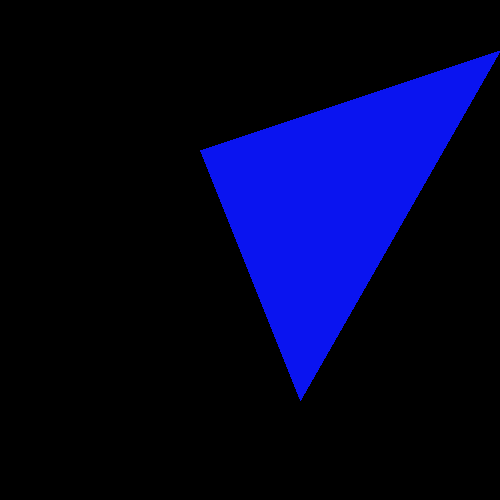

In [1]:
from PIL import Image, ImageDraw
from IPython.display import display

W = 500
H = 500

image_1 = Image.new('RGB', (W, H))
draw = ImageDraw.Draw(image_1, 'RGBA')
draw.polygon([(500, 50), (300, 400), (200, 150)], (10, 20, 240, 255))
display(image_1)

Com esse código conseguimos, definir a altura e largura da nossa imagem pelos parâmetros `W` e `H`, respectivamente. Assim, criamos uma imagem vazia usando o método `Image.new`, que recebe a dimensão definida pela tupla `(W,H)` e já define canais RGB a partir do argumento `RGB`. Assim, podemos usar `ImagemDraw` e `.polygon` para desenhar nosso polígono, em que definimos as coordenadas dos vértices do polígono pela lista de tuplas `[(500, 50), (300, 400), (200, 150)]`, além de receber os valores de RGBA na tupla `(10, 20, 240, 255)`, em que __R__ é o canal vermelho; __G__ é o canal verde; __B__ é o canal azul e __A__ é o valor de opacidade do polígono. Com isso, usamos a função `display` do IPython `para` mostrar o polígono.

É importante explicítar que os parâmentros R, G, B e A podem assumir valores que variam no intervalo de $[0, 255]$. Já as coordenadas $x$ e $y$ dos vértices variam de acordo com $[0, w]$ e $[0, h]$, respectivamente, em que $w$ é a altura da imagem e $h$, a largura.

Além disso, podemos também criar múltiplos polígonos e fazer uma sobreposição deles. O código funciona de forma muito similar, sendo a única alteração que usamos a função `draw` múltiplas vezes para cada diferente polígono.

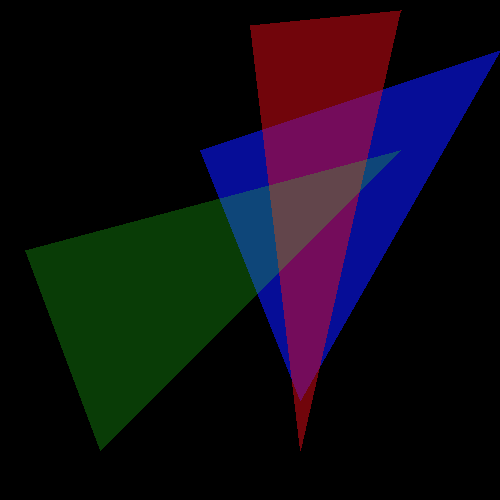

In [2]:
image_2 = Image.new('RGB', (W, H))
draw = ImageDraw.Draw(image_2, 'RGBA')
draw.polygon([(500, 50), (300, 400), (200, 150)], (10, 20, 240, 160)) 
draw.polygon([(250, 25), (400, 10), (300, 450)], (240, 10, 24, 120)) 
draw.polygon([(25, 250), (400, 150), (100, 450)], (40, 255, 24, 60)) 
display(image_2)

Porém, o objeto do tipo PIL das imagens geradas não são as mais comuns em processamento de imagem. Por isso, geralmente usamos outras bibliotecas para converter e aplicar outros algoritmos e métodos. Um objeto muito usado para representar são arrays de `numpy` e também vamos usar imagens no tipo da biblioteca  `OpenCV` para computar uma das funções de fitness. Enfim, vamos converter nossas imagens:

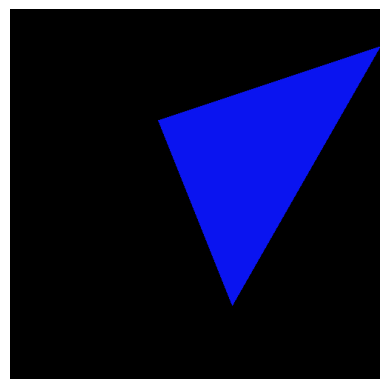

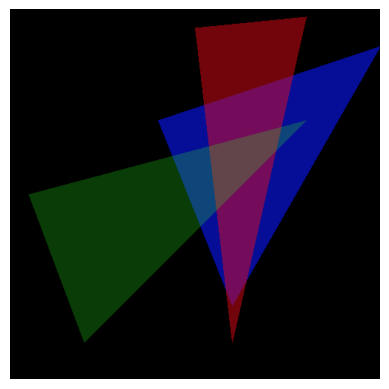

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


n_pixels = W*H

image1_np = np.array(image_1)

image1_cv = cv2.cvtColor(image1_np, cv2.COLOR_RGB2BGR)

image2_np = np.array(image_2)
image2_cv = cv2.cvtColor(image2_np, cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(image1_cv, cv2.COLOR_BGR2RGB))
plt.axis('off') 
plt.show()


plt.imshow(cv2.cvtColor(image2_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

Aqui, usamos o método `np.array` para converter nossa imagem para array e também convertemos nossa imagem para o formato do OpenCV usando `cv2.cvtColor`, em que `cv2.COLOR_RGB2BGR` apenas serve para definir o _color map_ RGB. Assim, usamos `matplotlib` para exibir nossas imagens. 

## Definição do _fitness_ do problema

Na referência $[4]$, os autores definem duas funções de _fitness_ principais: o __Erro Médio Quadrado__ (MSE) para pixel e a __Similaridade Estrutural__ (SSIM). O primeiro consiste em simplesmente somar as diferenças ao quadrado de todos os pares de pixels correspondentes na imagem original e recriada, dividindo essa soma pela número de pixels, dado pelo produto da largua e altura. Formalmente, ele é definido como $[5]$: 
$$\text{MSE} = \frac{1}{N}\sum \sum (E_{ij} - o_{ij})^2 $$

em que $N$ é o número de pixels da imagem, $E_{ij}$ um pixel da nova imagem e $o_{ij}$ o pixel correspondente da imagem original. Implementando isso em código, podemos fazer de forma simples com a biblioteca do `OpenCV`. 

In [4]:
MSE = np.sum((image1_cv.astype("float") - image2_cv.astype("float")) **2)/float(n_pixels)
print(f'MSE = {MSE}')

MSE = 4747.731712


Já o SSIM é uma métrica um pouco mais complexa, pois leva em consideração valores estatísticos das imagens e algumas constantes $[6]$. Sua formulação parte da definição de três paramêtros: 
\begin{align}
l(\mathbf{x}, \mathbf{y}) &= \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1} \\
c(\mathbf{x}, \mathbf{y}) &= \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2} \\
s(\mathbf{x}, \mathbf{y}) &= \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}
\end{align}
em que $x$ e $y$ são as imagens sendo comparadas. Assim:
* $\mu_x$ é a média de uma amostra de pixels da imagem $x$;
* $\mu_y$ é a média de uma amostra de pixels da imagem $y$;
* $\sigma_x^2$ é a variância de $x$;
* $\sigma_y^2$ é a variância de $y$;
* $\sigma_{xy}$ é a covariância de $x$ e $y$;
* $c_1 =(k_1L)^2, c_1 =(k_2L)^2 e c_3 =c_2/2 $ são três constantes pequenas;
* $L$ é um intervalo dinâmico dos valores de pixels que depende dos bits ($L = 255$ para $8$ bits/pixel em imagem de escala cinza);
* $k_1 = 0.01$ e $k_2 = 0.03$, por definição.

Denotamos $l(\mathbf{x}, \mathbf{y})$, $c(\mathbf{x}, \mathbf{y})$ e $s(\mathbf{x}, \mathbf{y})$ como luminância, contraste e estrutura, respectivamente. Formulamos o SSIM usando uma combinação dessas três componentes:

$$\text{SSIM}(\mathbf{x}, \mathbf{y}) = [l(\mathbf{x}, \mathbf{y})]^\alpha \cdot[s(\mathbf{x}, \mathbf{y})]^\beta \cdot[c(\mathbf{x}, \mathbf{y})]^\gamma$$

Se igularmos $\alpha = \beta = \gamma = 1$, temos um caso especial:

$$\text{SSIM}(\mathbf{x}, \mathbf{y}) = \frac{(2 \mu_x \mu_y + C_1)+(2\sigma_{xy}+C_2)}{(\mu_x^2 + \mu_y^2 + C_1)+(\sigma_x^2 + \sigma_y^2 + C_2)}$$

Podemos usar uma função do `sklearn` para computar o SSIM.

In [5]:
from skimage.metrics import structural_similarity

SSIM_img1_2 = structural_similarity(image1_cv, image2_cv, channel_axis=2)
print(f'SSIM = {SSIM_img1_2}')

SSIM = 0.7607639241949956


## Definição do indivíduo e população

Como já discutimos iremos recriar uma imagem usando polígonos criados a partir das coordendas dos vértices e os componentes RGBA $[4]$. Com isso, o número de parâmetros é definido como:

$$ \text{número de parâmetros} = \text{(número de polígonos)} \cdot 2 \cdot (\text{número de vértices}) + 4 $$

Sabemos também que a imagem recriada é composta por diversos polígonos, então nosso índividuo será um conjunto de polígons, em que o número de genes é o produto do número de parâmetros e polígonos. Assim, nosso indivíduo pode ser estruturado como uma lista que armazena todos os parâmetros de todos os polígonos em sequência: 

```python
individuo = [x1, y1, x2, y2, x3, y3, R, G, B, A]
```
Nesse caso, o indivíduo tem apenas 1 polígono e número de vértice $=3$ (ou seja, o número de pârametros é 10). Na referência $[4]$, os valores do parâmetros são todos dados no intervalo de $[0,1]$ e que são expandidos antes do desenho de acordo com a altura para $y$, largura para $x$ e $255$ para RGBA. Assim, para o plot, o código itera selecionado de 10 em 10, passando os polígonos separadamente.

Como consequência, a população será uma lista de listas que conterá diversos indivíduos com seus respectivos genes.

## Classe `ImageTest`

Os autores da referência $[4]$ criaram uma classe que recebe a imagem que será recriada e o número de vértices do polígonos (para calcular os parâmetros). Nessa classe, existem 4 métodos essenciais:

```python
polygonDataToImage(self, polygonData)

getDifference(self, polygonData, method="MSE")

plotImages(self, image, header=None)

saveImage(self, polygonData, imageFilePath, header=None)
```

* O `polygonDataToImage` recebe os parâmetros do polígono e plota o polígono na imagem.

* O `getDifference` recebe os parâmetros e computa a função de fitness, sendo possível alterar o método entre `MSE` e `SSIM` no argumento `method`.

* O `plotImages` recebe a imagem que está sendo recriada e faz uma comparação lado a lado com a imagem original com um título no argumento `header`.

* O `saveImage` simplesmente salva a comparação das duas imagens em um caminho dado pelo usuário em `imageFilePath`, além do título em `header`.

## Implementação do algoritmo genético

Vamos começar a discutir a implementação do algoritmo genético, começando pelos imports.

In [6]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms 

import random
import numpy
import os

import image_test
import callback

import matplotlib.pyplot as plt
import seaborn as sns

A função de cada import está descrito no arquivo README do repositório, com exceção das classes `image_test` e `callback`, que serão explicadas no decorrer do notebook.

### Constantes

Em relação às constantes, vamos dar uma breve definição da sua utilidade $[4]$, lembrando que elas podem ser alteradas pelo usuário.

* `POLYGON_SIZE` controla o número de vértices do polígono;
* `NUM_OF_POLYGONS` define o número de polígonos que são plotados na imagem;
* `NUM_OF_PARAMS` corresponde ao número de parâmetros que um indivíduo carrega;
* `POPULATION_SIZE` é o tamanho da população;
* `P_CROSSOVER` é a probabilidade de cruzamento;
* `P_MUTATION` é a probabilidade de mutação;
* `MAX_GENERATIONS` carrega o número máximo de gerações que o algoritmo itera;
* `HALL_OF_FAME_SIZE` é o tamanho do hall da fama;
* `CROWDING_FACTOR` é um parâmetro que controla o quão parecido é o mutante do indivíduo e original ou então do filho em relação aos pais.
* `RANDOM_SEED` semente passada para o módulo `random` para fixá-la.

In [13]:
POLYGON_SIZE = 3
NUM_OF_POLYGONS = 100

NUM_OF_PARAMS = NUM_OF_POLYGONS * (POLYGON_SIZE * 2 + 4)

POPULATION_SIZE = 200
P_CROSSOVER = 0.9 
P_MUTATION = 0.55  
MAX_GENERATIONS = 2000
HALL_OF_FAME_SIZE = 20
CROWDING_FACTOR = 10.0  

RANDOM_SEED = 6431
random.seed(RANDOM_SEED)

### Inicialização do `ImageTest`

Vamos usar o `ImageTest` para carregar uma imagem da cabeça da Mona Lisa, que será a imagem para recriarmos. Escolhemos essa imagem porque é a mesma usada na referência $[4]$, a fim de conseguirmos fazer um comparativo ao final. Também definimos em `BOUNDS_LOW, BOUNDS_HIGH` os limites que definem o intervalo de valores que os parâmetros podem assumir.

In [8]:
imageTest = image_test.ImageTest("Mona_Lisa_head.png", POLYGON_SIZE)

NUM_OF_PARAMS = NUM_OF_POLYGONS * (POLYGON_SIZE * 2 + 4)

BOUNDS_LOW, BOUNDS_HIGH = 0.0, 1.0 

### Implementação do `deap`

O DEAP é um módulo muito importante porque é ele que irá estruturar o nosso algoritmo genético. O submódulo `base` permite que a gente crie e registre ferramentas para o algoritmo. Assim, começamos criando uma instãncia da classe `Toolbox` para criar nossa "caixa de ferramentas", que irá receber todos os operadores genéticos, função de fitness, entre outros. Vamos usar o submódulo `creator` e seu método `create` para registrar o fitness e o indivíduo. É importante perceber que o criador do fitness recebe um argumento `weights=(-1.0,))`, que por ser $-1$ implica em um problema de minimização. Além disso, ao criar o indivíduo, específicamos que ele será uma lista ao passar o argumento `list`.

Os autores da referência $[4]$ definem a função `randomFloat` para gerar os valores aleatórios entre $0$ e $1$ que irão preencher os genes do indivíduo. Com isso, adicionamos essa função na `toolbox` com o nome de `attrFloat`. Enfim, criamos um criador de indivíduos que usa o método `tools.initIterative` para gerar indivíduos repetidamente, usando a ferramenta de gerar valores aleatórios na estrutura de dados definido pelo `Individual`. Como consequência, também podemos criar um gerador de população que usa o gerador de indivíduos repetidamente em uma lista.

In [19]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", list, fitness=creator.FitnessMin)


def randomFloat(low, up):
    """Gera valores aleatórios delimitados pelo intervalo [low, up].
    
    Args:
        low: valor que delimita o início do intervalo.
        up: valor que delimita o fim do intervalo.
    
    Returns:
        Uma lista de tamanho NUM_OF_PARAMS com valores aleatórios delimitados
        por [low, up]
    
    """
    return [random.uniform(l, u) for l, u in zip([low] * NUM_OF_PARAMS, [up] * NUM_OF_PARAMS)]



toolbox.register("attrFloat", randomFloat, BOUNDS_LOW, BOUNDS_HIGH)

toolbox.register("individualCreator",
                 tools.initIterate,
                 creator.Individual,
                 toolbox.attrFloat)

toolbox.register("populationCreator",
                 tools.initRepeat,
                 list,
                 toolbox.individualCreator)

### Fitness e operadores no `deap`

Vamos definir agora nossa função de fitness e os operadores de seleção, cruzamento e mutação. Para a função objetivo, vamos usar a função `getDiff`, que recebe um indivíudo e computa o MSE ou SSIM desse indivíduo com a imagem original. Então, registramos essa função de `getDiff` no `toolbox`. 

Nosso operador de seleção escolhido foi o de torneio e como ele já possui uma implementação nativa no `deap`, usamos a função `tools.selTournament` com tamanho de torneio igual a $2$ [7].

O operador de cruzamento foi mantido como o da referência [4], que é o `cxSimulatedBinaryBounded`, o qual possui implementação nativa no deap.

O operador de mutação é a primeira mudança maior que fizemos no código original, já que decidimos usar uma mutação uniforme, ao invés da mutação polinomial, usada pelos autores $[4]$. Assim, decidimos usá-la porque queremos testar se ela consegue ajudar na convergência nesse problema contínuo que possui um enorme espaço de busca.

In [21]:
def getDiff(individual):
    """Computa o fitness do indivíduo
    
    Args: 
        individual: indivíduo gerado pelo individualCreator.
        
    Returns: 
        Uma das métricas escolhidas pelo usuário. Caso ele queira computar o
        MSE, basta comentar a linha do SSIM, sendo que o mesmo vale para o 
        contrário. 
    
    """
    return imageTest.getDifference(individual, "MSE"),
    #return imageTest.getDifference(individual, "SSIM"),

toolbox.register("evaluate", getDiff)


toolbox.register("select", tools.selTournament, tournsize=2)

toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutUniformInt,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 indpb=1.0/NUM_OF_PARAMS)

Com isso, já temos quase tudo que é necessário para rodar o algoritmo genético.

## Implementação do `saveImage`

Outra função interessante usada pelos autores é a `saveImage`que usa a `imageTest.saveImage` para salvar os resultados a cada 100 gerações, criando até um diretório separado usando o módulo `os`. 

In [22]:
def saveImage(gen, polygonData):
    """Cria uma pasta com os resultados do algoritmo a cada 100 gerações.
    
    Args:
        gen: geração atual do algoritmo.
        polygonData: parâmetros do polígono
    
    """

    if gen % 100 == 0:

        folder = "resultados/exec-{}-{}".format(POLYGON_SIZE, NUM_OF_POLYGONS)
        if not os.path.exists(folder):
            os.makedirs(folder)

        imageTest.saveImage(polygonData,
                            "{}/Depois de-{}-gens.png".format(folder, gen),
                            "Depois de {} gerações".format(gen))


Enfim, podemos rodar nosso algoritmo genético.

## Execução do Algoritmo Genético

Para executar nosso algoritmo, primeiro vamos configurar o criador de população, passando o argumento `POPULATION_SIZE`. Além disso, vamos criar estatísticas para que elas sejam registradas durante o passar das gerações. Assim, vamos computar a média do fitness e o fitness mais baixo (mínimo).

Também vamos criar um hall da fama usando a função `tools.HallOffFame`. Agora, se estivessmos usando um algoritmo normal, usariamos a função `eaSimple` do `deap`para executar o algoritmo. Contudo, os autores da referência $[4]$ criaram uma função muito similar, mas implementando um callback e um sistema de elitismo. Com isso, decidimos retirar esse sistema para tentar observar alguma melhora na convergência, já que supômos que usar elitismo em um problema com um espaço de busca tão grande poderia perpetuar indíviduos que ainda estariam muito longes da solução mais ótima. Por isso, a ausência dele poderia trazer uma maior variabilidade para o hall da fama e, talvez, convergir um pouco melhor.

O script `.py` com a modificação do elitismo pode ser encontrado no repositório, com o nome de `elitism_callback.py`. Além disso, nós mantivémos o callback, que atua junto com a função `saveImage`para salvar as melhores imagens a cada 100 gerações.

Dito isso, usamos a função `eaSimpleWithCallback` do script `callback.py`, adaptado por nós. Então, preenchemos todos os argumentos que são padrão de um `eaSimple` comum e apenas adicionamos a função `saveImage` para ser aplicada no callback. 

Por fim, ao terminar o algoritmo, iremos mostrar a melhor solução, seu fitnesse e uma comparação lado a lado com a imagem original, juntamente com um gráfico com as curvas de fitness mínimo e médio ao longo das gerações.

gen	nevals	Mínimo 	Média  
0  	200   	22828.5	31156.1
1  	197   	23421.5	30308.8
2  	190   	22044.5	29698.1
3  	188   	21642.1	28941.8
4  	187   	22654.6	28576.2
5  	189   	20978.5	28077.2
6  	196   	21886  	27712.5
7  	187   	19664.3	27826.6
8  	195   	20790.8	27185.4
9  	195   	20861  	26641.2
10 	188   	20954.3	26383.1
11 	190   	20975.2	26002.2
12 	191   	19486.7	25720.6
13 	189   	20322.5	25615.8
14 	191   	20173.5	25435.7
15 	191   	19495.3	25065.8
16 	192   	18648.5	24701.2
17 	183   	20112.4	24527.9
18 	197   	19169.3	24188.8
19 	190   	19619  	24127.7
20 	189   	19473.2	23695.4
21 	188   	17752.3	23555.2
22 	191   	18835.6	23372.6
23 	196   	19392  	23460.9
24 	191   	18983.9	23248.5
25 	191   	18969  	22966.6
26 	192   	18565.4	22751.7
27 	185   	18510.5	22473.8
28 	191   	17218.3	22233.1
29 	188   	18054.7	21980.8
30 	194   	18109.4	21962.7
31 	188   	18109.4	21809.3
32 	186   	18018.7	21544.1
33 	191   	17405.8	21141  
34 	193   	16834.9	21352.1
35 	192   	16834.9	21362.9
3

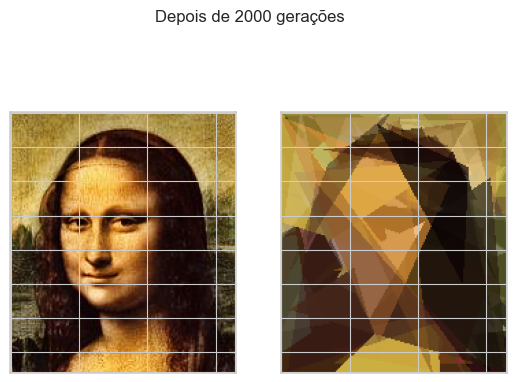

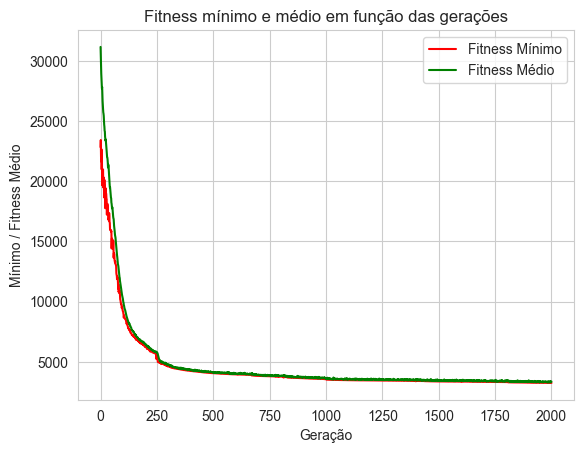

In [14]:
def main():

    population = toolbox.populationCreator(n=POPULATION_SIZE)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("Mínimo", numpy.min)
    stats.register("Média", numpy.mean)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


    population, logbook = callback.eaSimpleWithCallback(population,
                                                        toolbox,
                                                        cxpb=P_CROSSOVER,
                                                        mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS,
                                                        callback=saveImage,
                                                        halloffame=hof,
                                                        stats=stats,
                                                        verbose=True)
    best = hof.items[0]
    print()
    print("Melhor solução  = ", best)
    print()
    print("Melhor fitness = ", best.fitness.values[0])
    print()

    imageTest.plotImages(imageTest.polygonDataToImage(best))

    minFitnessValues, meanFitnessValues = logbook.select("Mínimo", "Média")

    sns.set_style("whitegrid")
    plt.figure("Estatísticas:")
    plt.plot(minFitnessValues, color='red', label='Fitness Mínimo')
    plt.plot(meanFitnessValues, color='green', label='Fitness Médio')
    plt.xlabel('Geração')
    plt.ylabel('Mínimo / Fitness Médio')
    plt.title('Fitness mínimo e médio em função das gerações')
    plt.legend()

    plt.show()

if __name__ == "__main__":
    main()

## Resultados e Discussão

Vemos que as curvas de fitness começam com valores distantes e com o passar das gerações, elas passam a se sobrepor e adotar valores parecidos. Além disso, o fitness médio decai muito nas primeiras duzentas gerações, mas perto da geração de número 500, o fitness passa a diminuir de forma bem devagar, um indicativo de que o algoritmo não está conseguindo mais evoluir de forma eficiente.

Outra observação importante é que os valores de fitness mínimo variam de forma irregular, com oscilações em que o mínimo aumenta e diminui com o avanço das gerações. Isso mostra uma possível consequência da retirada do elitismo, já que o fitness mínimo de uma geração para a outra pode flutuar, já que não preservamos os melhores indivíduos.

A imagem abaixo foi retirada do livro $[4]$ no qual baseamos o código, e podemos ver que a imagem obtida pelo nosso algoritmo aparenta ter uma semelhança menor com a Mona Lisa do que a do livro. 

![Comparativo](comparativo_livro.png)

Como conclusão, é possível dizer que nossa alteração não aparentou ser benéfica para a convergência do problema. Então, mesmo com um espaço de busca tão amplo, ainda é interessante manter o sistema de elitismo e a mutação polinomial. Contudo, esse trabalho ainda foi importante para aprender sobre reconstrução de imagem e utilização do módulo `deap`

## Perspectivas Futuras

Visando melhorar esse projeto, seria possível, no futuro, implementar uma otimização multi-objetivo, otimizando tanto o MSE quanto o SSI. Além disso, seria útil procurar diferentes algoritmos de reconstrução, já que os polígonos podem se tornar um método custoso quando aumentamos muito o número de polígonos e o número de vértices.

Também seria interessante testar esse algoritmo do livro [4] em imagens de escala cinza, que tem apenas um canal de cor, ao invés de três. Existe a possibilidade de que haja uma convergência melhor no fitness para imagens em preto e branco, já que o espaço de busca diminui considerávelmente, afinal, existem dois parâmetros fixos a menos para serem otimizados.

## Referências

$[1]$ Notebok 1.3 e 1.5 da disciplina de Algoritmos Genéticos, de autoria do professor.

$[2]$ Notebook 2.3 da disciplina de Algoritmos Genéticos, de autoria do professor.

$[2]$ Mirjalili, S., Song Dong, J., Sadiq, A. S., & Faris, H. (2020). Genetic algorithm: Theory, literature review, and application in image reconstruction. Nature-inspired optimizers: Theories, literature reviews and applications, 69-85.

$[4]$ Wirsansky, E. (2020). Hands-on genetic algorithms with Python: applying genetic algorithms to solve real-world deep learning and artificial intelligence problems. Packt Publishing Ltd.

$[5]$ Nadipally, M. (2019). Optimization of methods for image-texture segmentation using ant colony optimization. In Intelligent data analysis for biomedical applications (pp. 21-47). Academic Press.

$[6]$ Wang, Z., Simoncelli, E. P., & Bovik, A. C. (2003, November). Multiscale structural similarity for image quality assessment. In The Thrity-Seventh Asilomar Conference on Signals, Systems & Computers, 2003 (Vol. 2, pp. 1398-1402). Ieee.

$[7]$ [Documentação da seleção por torneio no deap](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournament). 